#SFS Tuning for PID-PD Controller

##Import Library

In [3]:
!pip install control
!pip install ipython-autotime
%load_ext autotime

import numpy as np
from control import *
from control.matlab import *
import matplotlib.pyplot as plt
import random as rnd
from math import ceil

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.06 s (started: 2021-04-19 01:25:22 +07:00)


##Gantry Crane Model

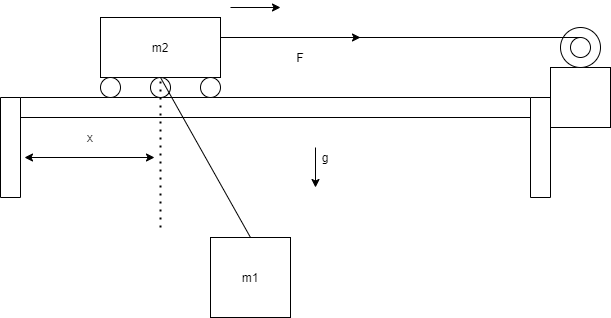

In [4]:
#gantry model

#parameters
m1 = 1            #payload
m2 = 1.5          #trolley
l = 0.5           #rope length
g = 9.81          #gravitational acceleration
D = 12.32         #damping constant
R = 0.5           #motor resistant
Kt = 0.0071619    #torque constant
Ke = 0.0071619    #electric constant
rp = 0.012        #pulley radius
r = 1             #gear ratio

#state space representation
a = ((R*rp)/(Kt*r))*(m1+m2)
b = ((Ke*r)/(rp))+((D*R*rp)/(Kt*r))
c = ((m1*l*R*rp)/(Kt*r))

a22 = (-b)/(a -(c/l))
a23 = (c*g)/(l*(a-(c/l)))
a42 = (b)/(a*(l-(c/a)))
a43 = (-g)/(l-(c/a))

b21 = 1/(a-(c/l))
b41 = (-1)/(a*(l-(c/a)))

A = [[0,1,0,0],
     [0,a22,a23,0],
     [0,0,0,1],
     [0,a42,a43,0]]

B = [[0],
     [b21],
     [0],
     [b41]]

Cp = [1,0,0,0]
Cs = [0,0,1,0]

D = [0]

ss_pos = ss(A,B,Cp,D)
ss_swy = ss(A,B,Cs,D)
tf_pos = tf(ss_pos)
tf_swy = tf(ss_swy)

tf_sys = [tf_pos,tf_swy]

time: 0 ns (started: 2021-04-19 01:25:31 +07:00)


##Closed Loop System

In [5]:
# Closed loop system
# Input argument :
# param : [Kp,Ki,Kd,Kps,Kds] (1x5 list)
# tf_sys : [tf_pos,tf_swy] (1x2 list)
# t_sim : (1xn list) or simulation duration

def closed_loop(param,tf_sys,t_sim): 
    pos,swy = tf_sys # pos: position transfer function, swy: sway transfer function

    Kp, Ki, Kd, Kps, Kds = param # Kp,Ki,Kd (position PID controller); Kps, Kds (sway angle PD controller)

    pid = tf([Kd, Kp, Ki],[1,0]) # position PID controller
    pd = tf([Kds,Kps],1) # sway angle PD controller

    #This is a SIMO system (Single Input Multiple Output), divide the output transfer function
    #to make it easier for simulation
    #Position Output
    feedblk1 = feedback(1,(pd*swy),sign=1) 
    pos_blk = feedback(pid*feedblk1*pos,1,sign=-1)
    [yp,_] = step(pos_blk,t_sim) 

    #Sway Output
    feedblk2 = feedback(1,pos*pid,sign=-1)
    feedblk3 = feedback(feedblk2*swy,pd,sign=1)
    swy_blk = pid*feedblk3
    [ys,_] = step(swy_blk,t_sim)

    #routh stability criterion
    # real poles < 0 == stable
    poles_p = pole(pos_blk)
    for i in poles_p.real:
        if i > 0:
            return False
        else:
            poles_s = pole(swy_blk)
            for i in poles_s.real:
                if i > 0:
                    return False

    return [yp,ys]

time: 0 ns (started: 2021-04-19 01:25:51 +07:00)


## Trajectory Reference

SSE = 7.467358866275475e-05 , SettlingTime = 4.24, RiseTime = 2.6, Oveshoot = 0.0


Text(0.5, 1.0, 'X reference model')

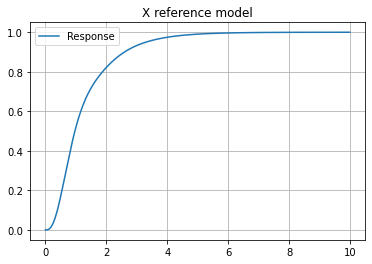

time: 125 ms (started: 2021-04-19 01:26:01 +07:00)


In [6]:
# refernce trajectory (step signal)
def step_signal(value,time):
    signal = np.zeros_like(time)
    signal[time>=0] = 1
    return value*signal

#x_ref model 3th order ITAE
#still editable and needs some check and validation
damp_rat = 0.7         #damping ratio
Ts = 1.7                   
w = 4/(damp_rat*Ts)
num = w**3
den = [1,1.75*w, 2.15*w**2, 1.5*w**3]
x_ref_tf = tf(num,den)
x_ref_sys = feedback(x_ref_tf,-1)

t_sim = np.arange(0,10,0.01)


[x_ref,_] = step(0.5*x_ref_sys,t_sim)  #simulating trajectory

#step info
SSE_x = abs(1 - x_ref[-1])
OS_x = (x_ref.max()/x_ref[-1]-1) #overshoot
Tr_x= t_sim[next(i for i in range(0,len(x_ref)-1) if x_ref[i]>x_ref[-1]*.90)]-t_sim[0] #rise time
try:
    Ts_x = t_sim[next(len(x_ref)-i for i in range(2,len(x_ref)-1) if abs(x_ref[-i]/x_ref[-1])<0.98)]-t_sim[0]
except StopIteration :
    eval_pos = False

print("SSE = {a} , SettlingTime = {b}, RiseTime = {c}, Oveshoot = {d}".format(a = SSE_x,b = Ts_x, c = Tr_x , d = OS_x))

plt.plot(t_sim,x_ref,label='Response')
plt.legend()
plt.grid()
plt.title('X reference model')

##Cost

In [7]:
#Cost Function 
def cost_func(x_ref,yp,ys,t):

    #cost function reference [1]
    dt = t[1]-t[0]

    t1 = 2.6     #rise time
    t2 = 4.24    #settling time

    idx1 = np.where(t==t1)[0][0]
    idx2 = np.where(t==t2)[0][0]

    #initial stage
    #ITSE performance index
    init_stage = np.multiply(t[0:idx1],(yp[0:idx1]-x_ref[0:idx1])**2)*dt
    j_initial = sum(init_stage)

    #sway cancelation
    swy_stage = np.multiply(t[idx1:-1],(ys[idx1:-1])**2)*dt
    j_cancel = sum(swy_stage)

    #final stage
    final_stage = np.multiply(t[idx2:-1],(yp[idx2:-1]-x_ref[idx2:-1])**2)*dt
    j_final = sum(final_stage)

    #total cost
    j = j_initial + j_cancel + j_final

    return j

time: 0 ns (started: 2021-04-19 01:26:12 +07:00)


##Generate Points, Sort Ranks, Bound Check

In [25]:
def generate_population(var_size,position_bound):
    """
    Generating random position and speed vector for each point.
    var_size is an array with dimension of (total population, n-dimension based on parameters)
    position_bound is an array with indicate the upper bound and lower bound of the parameter position
    """

    point_position = np.zeros(var_size)

    for i in range(var_size[0]):
        for j in range(var_size[1]):
            lim = position_bound[j]
            point_position[i][j] = lim[0] + np.random.random()*(lim[1]-lim[0])   # generate_point = lower_bound + rand[0,1]*(upper_bound-lower_bound)

    point_cost = np.zeros([np.array(point_position).shape[0],1])

    return [point_position,point_cost]

time: 0 ns (started: 2021-04-19 01:37:42 +07:00)


In [9]:
def sort_rank(point_position,point_cost):
    """
    The requirement for first updating process in SFS is sorting rank of the point position
    based on cost value. from minimum to maximum cost (ascending)
    """
    indices = np.argsort(point_cost,axis=0)      #sort index
    sorted_point = np.zeros(point_position.shape)          #sorted point position array
    sorted_cost = np.sort(point_cost,axis=0)   #sorted point cost

    #sorting
    for i in range(len(indices)):
        sorted_point[i] = point_position[indices[i]]

    return sorted_point,sorted_cost

time: 0 ns (started: 2021-04-19 01:26:36 +07:00)


In [29]:
def parameter_bound(point_position,position_bound):
    var_size = point_position.shape
    bounded_point = np.zeros(var_size)  #temporary array for bound checking
    for i in range(var_size[0]):
        for j in range(var_size[1]):
            lim = position_bound[j]
            if point_position[i][j] > lim[1] or point_position[i][j] < lim[0] :
                bounded_point[i][j] = lim[0] + (lim[1] - lim[0])*np.random.random() 

    return bounded_point

time: 0 ns (started: 2021-04-19 01:40:58 +07:00)


##Diffusion

In [37]:
def point_diffuse(point_position,max_diffuse,it,best_point,gauss_walk):
  new_point = np.zeros(point_position.shape)

  for i in range(max_diffuse):
    for j in range(len(point_position)):
      if np.random.rand() < gauss_walk :
        generate_point = rnd.gauss(best_point,abs((np.log(it+1)/(it+1))*(point_position[j]-best_point)))\
        +(np.random.rand()*best_point - np.random.rand()*point_position[j])
      
      else :
        generate_point = rnd.gauss(point_position[j],abs((np.log(it+1)/(it+1))*(point_position[j]-best_point)))

      new_point[j] = np.copy(generate_point)
  
  return new_point

time: 0 ns (started: 2021-04-19 01:53:22 +07:00)


## Updating Process

In [36]:
def first_update(point_position,var_size):
  """
    First updating process, updating each parameter/position in each point
    The process is similar to finding a local minimum
  """

  idx1 = np.random.permutation(var_size[0])
  idx2 = np.random.permutation(var_size[0])
  first_point = np.zeros(point_position.shape)

  for i in range(var_size[0]):
    for j in range(var_size[1]):
      pi = np.copy(point_position[i][j])        #current position
      pr = np.copy(point_position[idx1[i]][j])  #random position parameter
      pt = np.copy(point_position[idx2[i]][j])  #random position parameter

      if np.random.rand() > ((i+1)/len(point_position)): #probability 
        first_point[i][j] = pr - (pt-pi)*np.random.rand()    #first updating point
    
  return first_point

def second_update(first_point,best_position):
  """
    Second updating process, updating whole parameter/position in each point
    The process is similar to finding a global minimum 
  """
  second_point = np.zeros(point_position.shape)
  for i in range(len(first_point)):
     if np.random.rand() > (i+1)/len(first_point) : #probabillity

       idx1 = ceil(np.random.rand()*(len(first_point)-1))
       idx2 = ceil(np.random.rand()*(len(first_point)-1))

       while idx1 == idx2:
         idx2 = ceil(np.random.rand()*(len(first_point)-1))

       pi = np.copy(first_point[i])
       pr = np.copy(first_point[idx1])
       pt = np.copy(first_point[idx2])

       if np.random.rand() <= 0.5:
         second_point[i] = pi - np.random.normal()*(pt-best_position)
       elif np.random.rand() > 0.5:
         second_point[i] = pi + np.random.normal()*(pt-pr)

  return second_point

time: 0 ns (started: 2021-04-19 01:53:11 +07:00)


##Main Loop

###Initialize

In [34]:
max_gen = 500
n_sim = 5
max_point = 20
max_diffuse = 3
gauss_walk = 0.5
t_sim = np.arange(0,10,0.01)

r_kp = [-50, 200]
r_ki = [-50, 50 ]
r_kd = [-50, 100]
r_kps = [-50, 200]
r_kds = [-50, 100]

gain_bound = [r_kp, r_ki, r_kd, r_kps, r_kds]
var_size = [max_point,len(gain_bound)]

time: 0 ns (started: 2021-04-19 01:46:39 +07:00)


###Loop

In [38]:
global_history_cost = np.zeros(n_sim)
global_history_point = np.zeros([n_sim,var_size[1]])

for sim in range(n_sim):
    print('Initializing Optimization -------------------------{}'.format(sim))
    point_position,point_cost = generate_population(var_size,gain_bound)

    #First Evaluation
    for i in range(var_size[0]):
        cl_sim = closed_loop(point_position[i],tf_sys,t_sim)
        if cl_sim == False:
            point_cost[i] = np.Inf
        else :
            [yp,ys] = cl_sim
            cost = cost_func(x_ref,yp,ys,t_sim)
            point_cost[i] = np.copy(cost)

    point_position,point_cost = sort_rank(point_position,point_cost)

    """
    finding first best point and best cost for iteration benchmark
    Its because the array was sorted, so the best position is on the top (index = 0)
    """
    best_point = np.copy(point_position[0])  #first best point
    best_cost = np.copy(point_cost[0])          #first best cost

    for it in range(max_gen):
        """
        Step 1 : Generate new point using diffusion process
        """
        #Diffusion
        new_point = point_diffuse(point_position, max_diffuse, it, best_point, gauss_walk)
        new_point = parameter_bound(new_point,gain_bound)
        new_point_cost = np.zeros([var_size[0],1])
    
        #Cost calculation
        for i in range(var_size[0]):
            cl_sim = closed_loop(new_point[i],tf_sys,t_sim)
            if cl_sim == False:
                new_point_cost[i] = np.Inf
            else :
                [yp,ys] = cl_sim
                cost = cost_func(x_ref,yp,ys,t_sim)
                new_point_cost[i] = np.copy(cost)


        new_point,new_point_cost = sort_rank(new_point,new_point_cost)
        temp_best_point = np.copy(new_point[0])
        temp_best_cost = np.copy(new_point_cost[0])

        """
          Step 2 : Updating new point 
        """
        #First Updating Process
        first_point = first_update(new_point,var_size)
        first_point = parameter_bound(first_point,gain_bound)
        first_point_cost = np.zeros([var_size[0],1])

        #Cost Calculation
        for i in range(var_size[0]):
            cl_sim = closed_loop(first_point[i],tf_sys,t_sim)
            if cl_sim == False:
                first_point_cost[i] = np.Inf
            else :
                [yp,ys] = cl_sim
                cost = cost_func(x_ref,yp,ys,t_sim)
                first_point_cost[i] = np.copy(cost)

        #sorting Rank based on cost value
        first_point,first_point_cost = sort_rank(first_point,first_point_cost)

        #updating point based on cost value
        for i in range(var_size[0]):
            if first_point_cost[i] < new_point_cost[i]:
                new_point[i] = np.copy(first_point[i])
                new_point_cost[i] = np.copy(first_point_cost[i])
    
        temp_best_point = np.copy(new_point[0])       #updating temporary best position
        temp_best_cost = np.copy(new_point_cost[0])   #                   best cost

        #Second Updating Process
        second_point = second_update(new_point,temp_best_point)
        second_point = parameter_bound(second_point,gain_bound)
        second_point_cost = np.zeros([var_size[0],1])

        for i in range(var_size[0]):
            cl_sim = closed_loop(second_point[i],tf_sys,t_sim)
            if cl_sim == False:
                second_point_cost[i] = np.Inf
            else :
                [yp,ys] = cl_sim
                cost = cost_func(x_ref,yp,ys,t_sim)
                second_point_cost[i] = np.copy(cost)
    
        #sorting Rank based on cost value
        second_point,second_point_cost = sort_rank(second_point,second_point_cost)


        #updating new point based on cost value
        for i in range(var_size[0]):
            if second_point_cost[i] < new_point_cost[i]:
                new_point[i] = np.copy(second_point[i])
                new_point_cost[i] = np.copy(second_point_cost[i])
    
        #updating point (benchmark position) based on cost value
        for i in range(var_size[0]):
            if new_point_cost[i] < point_cost[i]:
                point_position[i] = np.copy(new_point[i])
                point_cost[i] = np.copy(new_point_cost[i])

        best_point = np.copy(point_position[0])
        best_cost = np.copy(point_cost[0])

        if (it+1) % 100 ==0 or (it+1)==1:
            print('Iterasi = {a} || Best Cost = {b}'.format(a=it+1,b=best_cost))
    global_history_cost[sim] = best_cost
    global_history_point[sim] = best_point

Initializing Optimization -------------------------0
Iterasi = 1 || Best Cost = [0.48895405]
Iterasi = 100 || Best Cost = [0.34564761]
Iterasi = 200 || Best Cost = [0.34564761]
Iterasi = 300 || Best Cost = [0.34564761]
Iterasi = 400 || Best Cost = [0.34564761]
Iterasi = 500 || Best Cost = [0.34564761]
Initializing Optimization -------------------------1
Iterasi = 1 || Best Cost = [0.43685849]
Iterasi = 100 || Best Cost = [0.32372669]
Iterasi = 200 || Best Cost = [0.32372669]
Iterasi = 300 || Best Cost = [0.32372669]
Iterasi = 400 || Best Cost = [0.32372669]
Iterasi = 500 || Best Cost = [0.32372669]
Initializing Optimization -------------------------2
Iterasi = 1 || Best Cost = [0.75110074]
Iterasi = 100 || Best Cost = [0.72632753]
Iterasi = 200 || Best Cost = [0.22265159]
Iterasi = 300 || Best Cost = [0.22265159]
Iterasi = 400 || Best Cost = [0.22265159]
Iterasi = 500 || Best Cost = [0.22265159]
Initializing Optimization -------------------------3
Iterasi = 1 || Best Cost = [0.558179]


## Testing

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


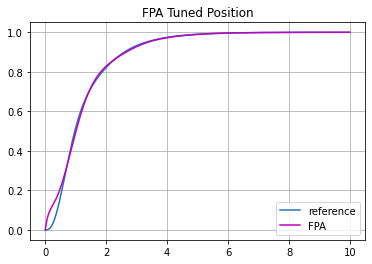

In [ ]:
#[yp,ys]= closed_loop(global_history_point[np.argmin(global_history_cost)],tf_sys,t_sim)

#SFS Gain
SFS_gain = [ 8.71423819,  0.        ,  1.40651713, 16.00728816,  3.53561121]
[yp1,ys1]= closed_loop(SFS_gain,tf_sys,t_sim)
cost = cost_func(x_ref,yp1,ys1,t_sim)

#PSO Gain
PSO_gain = [8.72335242e+00, 7.34558649e-03, 4.32397602e+00, 4.66974064e+01, 9.04354876e+00]
[yp2,ys2]= closed_loop(PSO_gain,tf_sys,t_sim)
cost = cost_func(x_ref,yp2,ys2,t_sim)

#FPA Gain
FPA_gain =  [8.69758115e+00, 2.89069672e-03, 1.54176825e+00, 1.69188668e+01, 3.93453515e+00]
[yp3,ys3]= closed_loop(FPA_gain,tf_sys,t_sim)
cost = cost_func(x_ref,yp3,ys3,t_sim)

plt.plot(t_sim,x_ref,label='reference')
#plt.plot(t_sim,yp1,label='SFS',color='r')
#plt.plot(t_sim,yp2,label='PSO',color='tab:orange')
plt.plot(t_sim,yp3,label='FPA',color='m')

plt.legend()
plt.grid()
plt.title('FPA Tuned Position')
plt.savefig('FPA_p Graph.jpg')
#print('Best Solution = {} || Cost = {}'.format(global_history_point[np.argmin(global_history_cost)],cost))
plt.show()

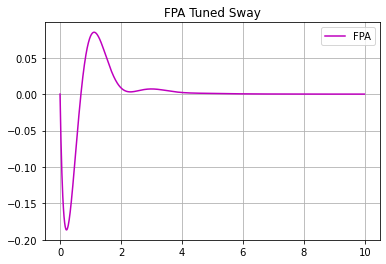

In [ ]:
#plt.plot(t_sim,ys2,label='PSO',color='tab:orange')
#plt.plot(t_sim,ys1,label='SFS',color='r')
plt.plot(t_sim,ys3,label='FPA',color='m')
plt.title('FPA Tuned Sway')
plt.legend()
plt.grid()
plt.savefig('FPA_s Graph.jpg')
plt.show()

In [ ]:
global_history_point[np.argmin(global_history_cost)]

array([ 8.71423819,  0.        ,  1.40651713, 16.00728816,  3.53561121])

In [ ]:
#[yp,ys]= closed_loop(global_history_point[np.argmin(global_history_cost)],tf_sys,t_sim)

#SFS Gain
SFS_gain = [ 8.71423819,  0.        ,  1.40651713, 16.00728816,  3.53561121]
[yp1,ys1]= closed_loop(SFS_gain,tf_sys,t_sim)
#cost = cost_func(x_ref,yp1,ys1,t_sim)

#PSO Gain
PSO_gain = [8.72335242e+00, 7.34558649e-03, 4.32397602e+00, 4.66974064e+01, 9.04354876e+00]
[yp2,ys2]= closed_loop(PSO_gain,tf_sys,t_sim)
#cost = cost_func(x_ref,yp2,ys2,t_sim)

#FPA Gain
FPA_gain =  [8.69758115e+00, 2.89069672e-03, 1.54176825e+00, 1.69188668e+01, 3.93453515e+00]
[yp3,ys3]= closed_loop(FPA_gain,tf_sys,t_sim)
#cost = cost_func(x_ref,yp3,ys3,t_sim)

#plt.plot(t_sim,yp1,label='SFS')
plt.plot(t_sim,yp2,label='PSO')
#plt.plot(t_sim,yp3,label='FPA')
plt.plot(t_sim,x_ref,label='reference')
plt.legend()
plt.grid()
plt.savefig('Position Graph.jpg')
#print('Best Solution = {} || Cost = {}'.format(global_history_point[np.argmin(global_history_cost)],cost))
plt.show()

NameError: ignored

In [ ]:
for i in FPA_gain:
  print(round(i,5))

8.69758
0.00289
1.54177
16.91887
3.93454
